# Google Landmark 2019

References:
4th place solution last year
https://www.kaggle.com/c/landmark-recognition-challenge/discussion/57896#latest-418704

Compressed and resized training and test images
https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-532165

https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-532193

EDA and loading data
https://www.kaggle.com/mayukh18/dataset-exploration-and-simple-on-the-fly-training



Plan

1. bring in training images that have >K examples for each class.  K=10
2. Train resnet34 on this and see xval score (basic classification)
3. Understand how to measure the metric being optimized in the contest
4. develop a heuristic/trained approach for submitting results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch


In [3]:
from smtplib import SMTP_SSL as SMTP
from email.mime.text import MIMEText
def send_txt(subject, body, toaddr="6519834115@tmomail.net"):
    fromaddr = "thebignotifier@gmail.com"
    msg = MIMEText(body, 'plain')
    msg['To'] = toaddr
    msg['Subject'] = subject

    server = SMTP('smtp.gmail.com')
    server.login(fromaddr, "eatbzltjueqfdopg")
    server.sendmail(fromaddr, toaddr, msg.as_string())
    server.quit()

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 200
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
num_workers = 5

In [5]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission7.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage1'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split1.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split2.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission5.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2

In [6]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [7]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [8]:
files = os.listdir(path_img)

In [9]:
#file_jpg = [k for k in files if '.jpg' in k]

In [10]:

#file_dict = {clean_string(x) : x for x in files if '.jpg' in x}


In [11]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [12]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [13]:
K=100
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 6513


In [14]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(1263760, 3)
Number of classes 6513


In [15]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [16]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [17]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
np.random.seed(42)
data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg',
                              ds_tfms=get_transforms(), size=224, bs=bs,
                              num_workers=num_workers).normalize(imagenet_stats)


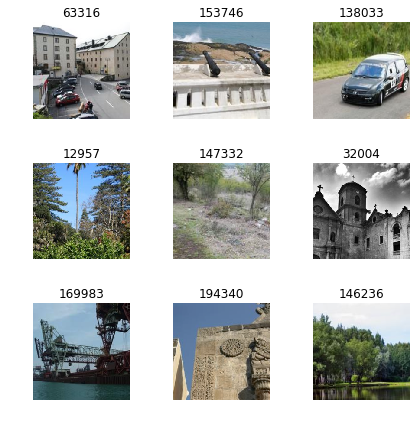

In [18]:
data.show_batch(rows=3, figsize=(6,6))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate).TTA()

KeyboardInterrupt: 

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [21]:
learn.freeze()
learn.fit_one_cycle(10)

In [22]:
learn.save('res34-stage-1')

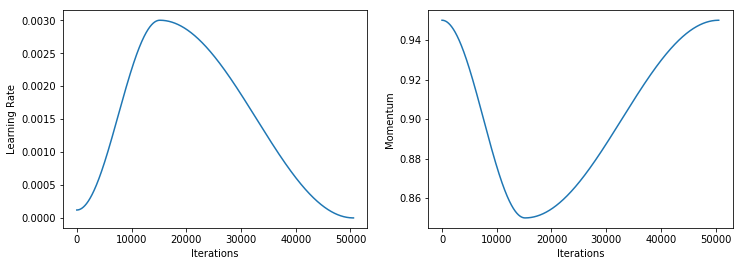

In [23]:
learn.recorder.plot_lr(show_moms=True)

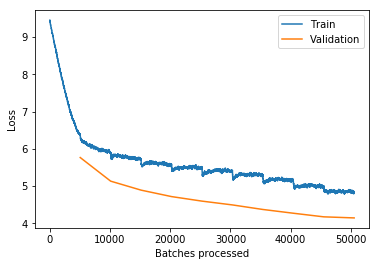

In [24]:
learn.recorder.plot_losses()

Min numerical gradient: 1.30E-03


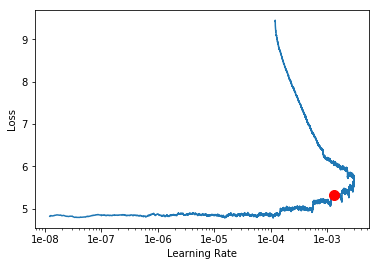

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
send_txt("!!","stage1 complete")

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

In [29]:
learn.load('res34-stage-1');

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06


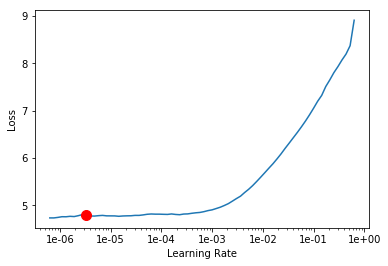

In [31]:
learn.recorder.plot(suggestion=True)

In [32]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-3))

In [33]:
learn.save('res34-stage-2')

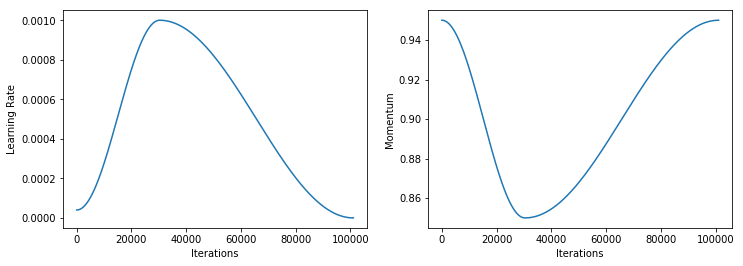

In [34]:
learn.recorder.plot_lr(show_moms=True)

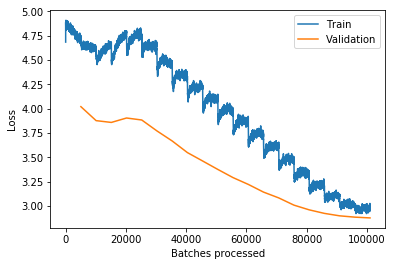

In [35]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-05


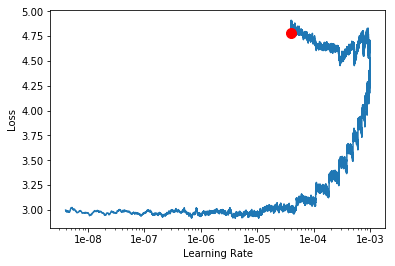

In [36]:
learn.recorder.plot(suggestion=True)

In [37]:
send_txt("!!","stage2 complete")

In [38]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

In [39]:
learn.save('res34-stage-3')

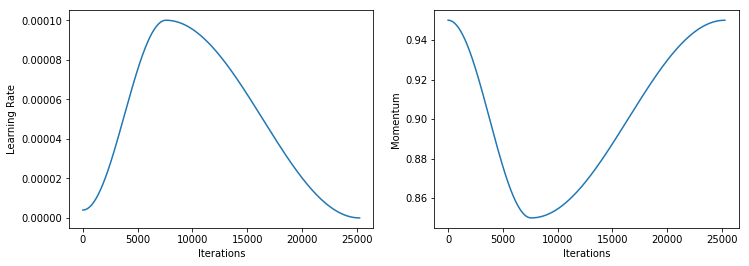

In [40]:
learn.recorder.plot_lr(show_moms=True)

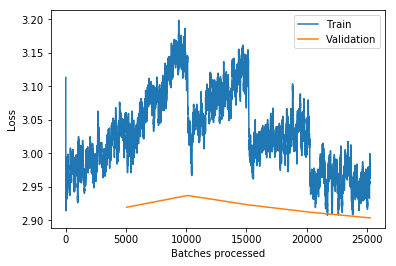

In [41]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-06


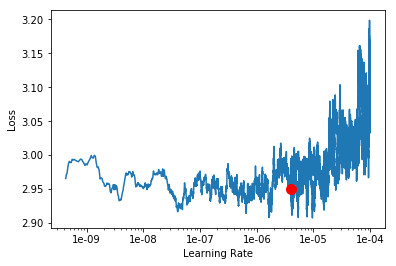

In [42]:
learn.recorder.plot(suggestion=True)

In [43]:
send_txt("!!","stage3 complete")

In [44]:
learn.fit(2, lr=slice(1e-5,1e-5))

In [45]:
learn.save('res34-stage-4')

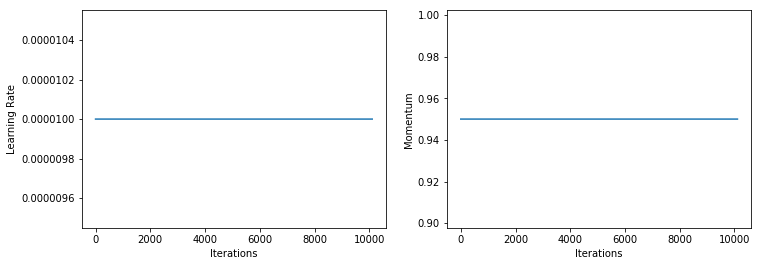

In [46]:
learn.recorder.plot_lr(show_moms=True)

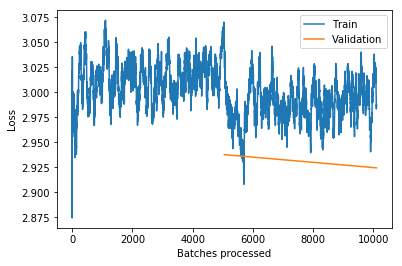

In [47]:
learn.recorder.plot_losses()

Min numerical gradient: 1.00E-05


/home/filip/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-05, right=1e-05
  self.set_xlim(upper, lower, auto=None)


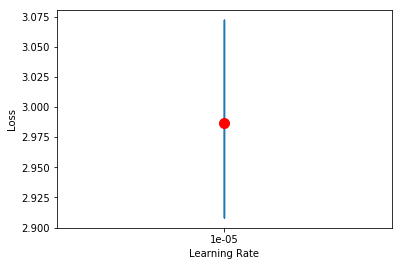

In [48]:
learn.recorder.plot(suggestion=True)

In [49]:
send_txt("!!","stage4 complete")

# Predict test set

In [50]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export("export.pkl")

#to load it
#learn = load_learner(path)


In [51]:
# path to test set
path_test = path / 'test_256-2/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2/test')

In [52]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [53]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

landmarks
id                                           
cc4e1335111d0f14   151942 0.19918443262577057
75f7113a26d670d9   135432 0.28332746028900146
3eeb10b0aa3cfbff   125425 0.10316508263349533
cefe5f969b9d4324    49267 0.46901482343673706
9324ef326508dda3    59470 0.07853130251169205
fa8a341223e53b45   104906 0.10658475011587143
a0b3a793f1b8e5c1    80177 0.20643113553524017
a4bbe52b528c33a4     72220 0.1587318778038025
7ab6befcb914f4f0   47133 0.040615104138851166
53d6f7ca907a7a3d   129232 0.18599499762058258
ca1eee0b836a2c94   100614 0.09112939238548279
0564160487c42150  164562 0.016140706837177277
9b08923c8315718d     167702 0.143316850066185
fc225e97eb1a7b14    190931 0.6780115962028503
adcf79fe84e625b5    168098 0.2908046841621399
b4c94dd2d6242fcd   33564 0.050648197531700134
ac528e00ca750217   134466 0.13518540561199188
72368267c0797ed2    144292 0.1211375817656517
fa8c0c1b03a11236    66151 0.07600537687540054
0bc6d88faf0a2014   142809 0.19141288101673126

In [54]:
submission.to_csv(path / 'submission5.csv',index=True)

# resubmit the last model with the new dataset

In [55]:
learn.load('stage-4');

## Predict test set

In [56]:
# path to test set
path_test = path / 'test_256-2/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2/test')

In [57]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [58]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

landmarks
id                                           
cc4e1335111d0f14    151942 0.3660988211631775
75f7113a26d670d9   142644 0.15841169655323029
3eeb10b0aa3cfbff   143221 0.05897347629070282
cefe5f969b9d4324    174697 0.5987585783004761
9324ef326508dda3     42755 0.3735222816467285
fa8a341223e53b45    104906 0.6905003190040588
a0b3a793f1b8e5c1     80177 0.8713388442993164
a4bbe52b528c33a4    72220 0.21105314791202545
7ab6befcb914f4f0  168137 0.030853552743792534
53d6f7ca907a7a3d    155413 0.4202963709831238
ca1eee0b836a2c94  177602 0.034549396485090256
0564160487c42150   100614 0.04839901998639107
9b08923c8315718d  167702 0.042714670300483704
fc225e97eb1a7b14    190931 0.8589565753936768
adcf79fe84e625b5    55276 0.15116140246391296
b4c94dd2d6242fcd  192056 0.028639744967222214
ac528e00ca750217    190931 0.1272725909948349
72368267c0797ed2     126465 0.063164122402668
fa8c0c1b03a11236    138982 0.0906650722026825
0bc6d88faf0a2014   188047 0.12719279527664185

In [59]:
submission.to_csv(path / 'submission6.csv',index=True)

## Interpret


In [20]:
learn.load('stage-4');

In [21]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (1011008 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
104169,2474,81049,138982,189446
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Valid: LabelList (252752 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
102544,108028,18615,21703,27190
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

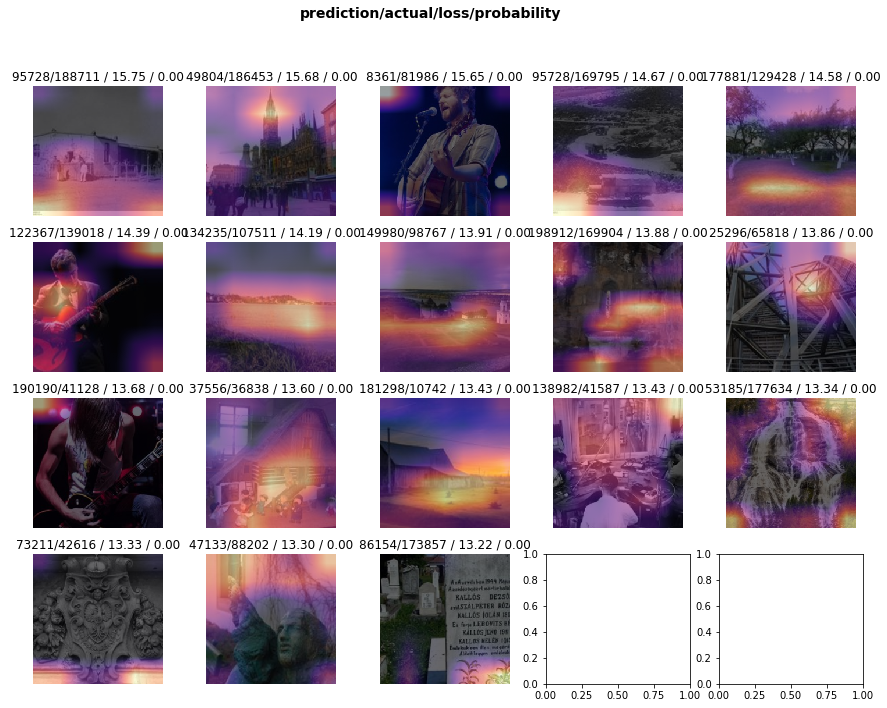

In [24]:
interp.plot_top_losses(18, figsize=(15,11))

# Continue training old model for another submission

In [25]:
learn.load('stage-4');

In [26]:
learn.fit(10, lr=slice(1e-8,1e-6))

In [27]:
learn.save('res34-stage-5')

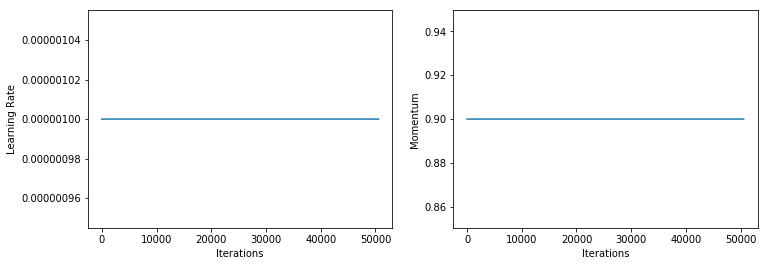

In [28]:
learn.recorder.plot_lr(show_moms=True)

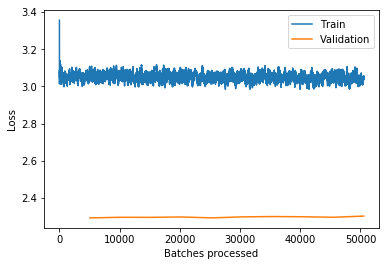

In [29]:
learn.recorder.plot_losses()

Min numerical gradient: 1.00E-06


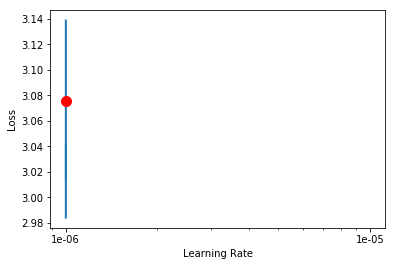

In [30]:
learn.recorder.plot(suggestion=True)

In [31]:
send_txt("!!","stage5 complete")

## Predict test set

In [32]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export("export.pkl")

#to load it
#learn = load_learner(path)


In [33]:
# path to test set
path_test = path / 'test_256-2/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2/test')

In [34]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [35]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

landmarks
id                                           
cc4e1335111d0f14    151942 0.3644765019416809
75f7113a26d670d9   135432 0.11542227864265442
3eeb10b0aa3cfbff   143221 0.05625518038868904
cefe5f969b9d4324    174697 0.6439326405525208
9324ef326508dda3    42755 0.42575421929359436
fa8a341223e53b45    104906 0.6505221724510193
a0b3a793f1b8e5c1      80177 0.856793224811554
a4bbe52b528c33a4    72220 0.22236397862434387
7ab6befcb914f4f0  168137 0.030901065096259117
53d6f7ca907a7a3d   155413 0.37158602476119995
ca1eee0b836a2c94   177602 0.03544068709015846
0564160487c42150    72220 0.04995410889387131
9b08923c8315718d  167702 0.038603249937295914
fc225e97eb1a7b14    190931 0.8435055017471313
adcf79fe84e625b5    55276 0.17020845413208008
b4c94dd2d6242fcd  192056 0.026510698720812798
ac528e00ca750217   190931 0.10092511028051376
72368267c0797ed2   126465 0.05712006986141205
fa8c0c1b03a11236   138982 0.08559973537921906
0bc6d88faf0a2014   188047 0.13018609583377838

In [36]:
submission.to_csv(path / 'submission7.csv',index=True)

## Interpret


In [20]:
learn.load('res34-stage-5');

In [21]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (1011008 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2474,6888,138982,189446,117635
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Valid: LabelList (252752 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
147998,154960,87421,8690,169189
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

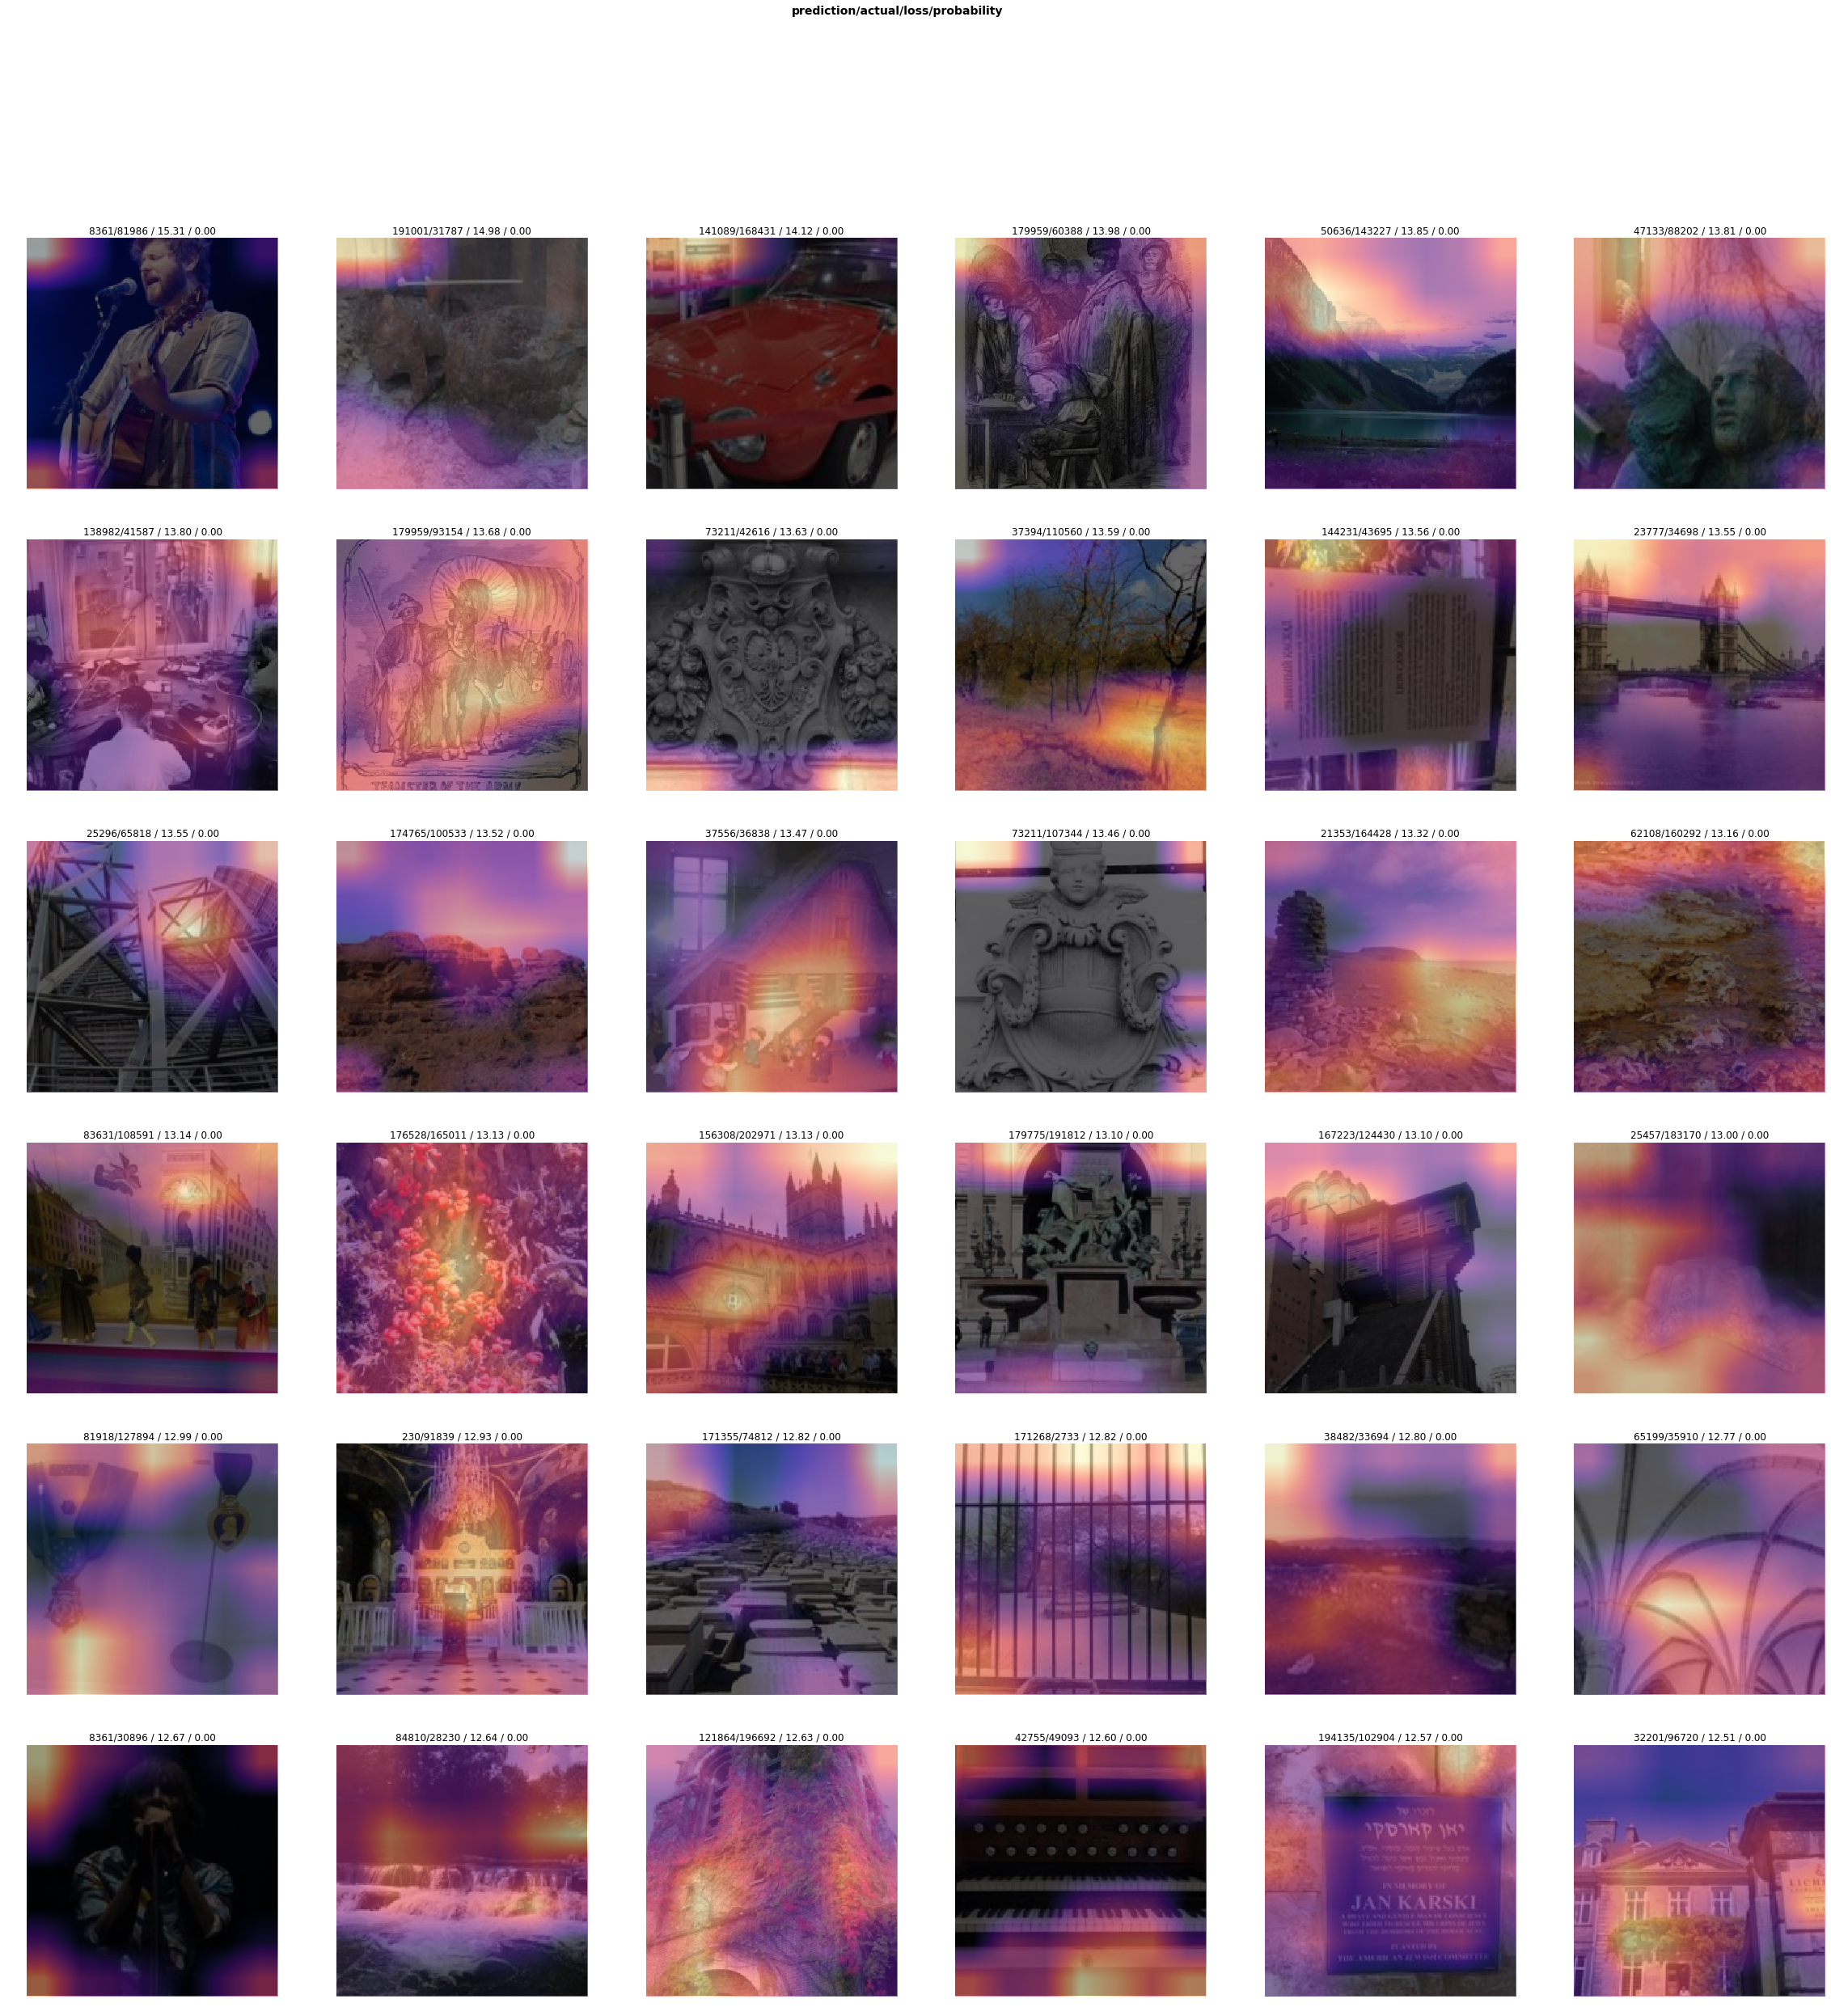

In [27]:
interp.plot_top_losses(36, figsize=(40,40))